In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-23 17:23:34.521151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 17:23:34.521170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_318729/194026773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [5]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24*2,
layer_depths = [30],
layer_count= 1,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.MLPModel()

Epoch 1/20


2022-03-23 17:23:37.813179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 17:23:37.813491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 17:23:37.813536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-23 17:23:37.813567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-23 17:23:37.813593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

132/132 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0059
Epoch 2/20
132/132 [==============================] - 0s 761us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 3/20
132/132 [==============================] - 0s 690us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 4/20
132/132 [==============================] - 0s 761us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 5/20
132/132 [==============================] - 0s 699us/step - loss: 0.0043 - val_loss: 0.0047
Epoch 6/20
132/132 [==============================] - 0s 693us/step - loss: 0.0043 - val_loss: 0.0047
Epoch 7/20
132/132 [==============================] - 0s 679us/step - loss: 0.0043 - val_loss: 0.0046
Epoch 8/20
132/132 [==============================] - 0s 740us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 9/20
132/132 [==============================] - 0s 685us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 10/20
132/132 [==============================] - 0s 673us/step - loss: 0.0042 - val_loss:

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1470      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


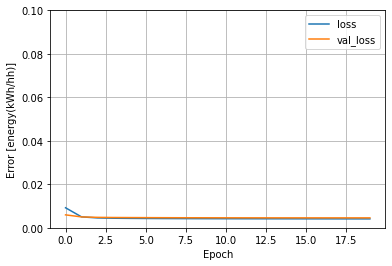

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [9]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

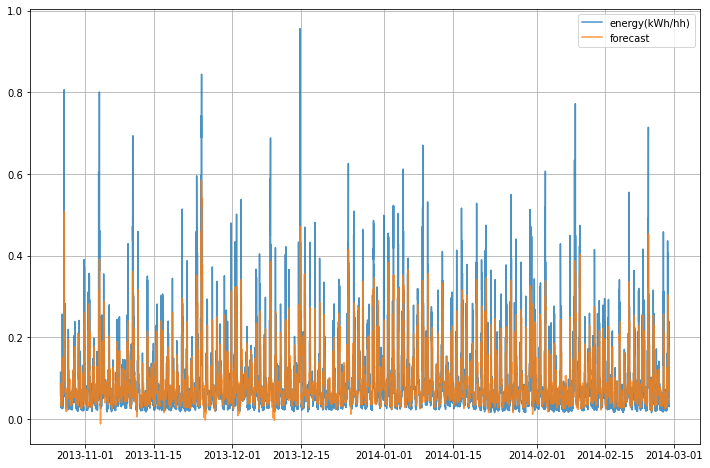

In [10]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_318729/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


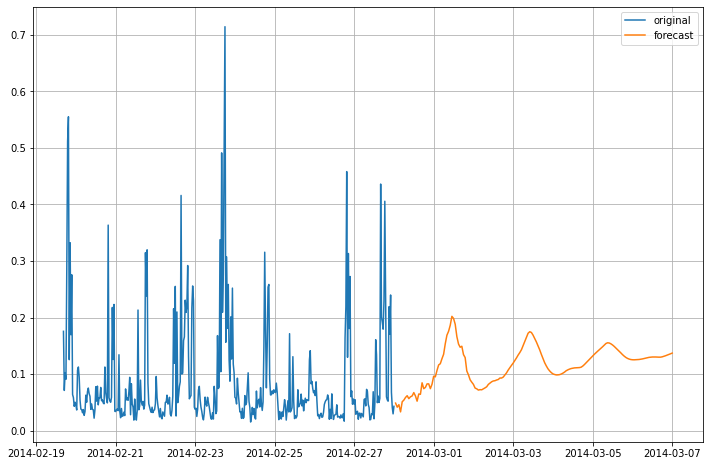

In [11]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [12]:
deep_learner.evaluateMSE()

0.00456908540752037

In [13]:
deep_learner.evaluateRMSE()

0.06759501022649801

In [14]:
deep_learner.evaluateMAE()

0.038261991576892

In [15]:
deep_learner.evaluateMAPE()

50.329504256454605

In [25]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    deep_learner = MLPModel(
        data = hh,
        Y_var = 'energy(kWh/hh)',
        lag = 24,
        layer_depths = [30],
        layer_count= 1,
        epochs = 30,
        batch_size = 256,
        train_test_split = 0.15
    )
    #training
    model = deep_learner.MLPModel()
    
    mse.append(deep_learner.evaluateMSE())
    rmse.append(deep_learner.evaluateRMSE())
    mae.append(deep_learner.evaluateMAE())
    mape.append(deep_learner.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



Epoch 1/30
66/66 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 2/30
66/66 [==============================] - 0s 825us/step - loss: 0.0038 - val_loss: 0.0060
Epoch 3/30
66/66 [==============================] - 0s 817us/step - loss: 0.0032 - val_loss: 0.0056
Epoch 4/30
66/66 [==============================] - 0s 697us/step - loss: 0.0030 - val_loss: 0.0053
Epoch 5/30
66/66 [==============================] - 0s 714us/step - loss: 0.0028 - val_loss: 0.0052
Epoch 6/30
66/66 [==============================] - 0s 876us/step - loss: 0.0027 - val_loss: 0.0051
Epoch 7/30
66/66 [==============================] - 0s 937us/step - loss: 0.0027 - val_loss: 0.0051
Epoch 8/30
66/66 [==============================] - 0s 699us/step - loss: 0.0026 - val_loss: 0.0050
Epoch 9/30
66/66 [==============================] - 0s 835us/step - loss: 0.0026 - val_loss: 0.0050
Epoch 10/30
66/66 [==============================] - 0s 917us/step - loss: 0.0026 - val_loss: 0.0050
E

66/66 [==============================] - 0s 902us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 23/30
66/66 [==============================] - 0s 823us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 24/30
66/66 [==============================] - 0s 925us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 25/30
66/66 [==============================] - 0s 909us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 26/30
66/66 [==============================] - 0s 928us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 27/30
66/66 [==============================] - 0s 851us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 28/30
66/66 [==============================] - 0s 853us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 29/30
66/66 [==============================] - 0s 933us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 30/30
66/66 [==============================] - 0s 827us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 1/30
66/66 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0044
Epoch

66/66 [==============================] - 0s 665us/step - loss: 0.0077 - val_loss: 0.0096
Epoch 14/30
66/66 [==============================] - 0s 958us/step - loss: 0.0077 - val_loss: 0.0097
Epoch 15/30
66/66 [==============================] - 0s 908us/step - loss: 0.0077 - val_loss: 0.0097
Epoch 16/30
66/66 [==============================] - 0s 712us/step - loss: 0.0077 - val_loss: 0.0098
Epoch 17/30
66/66 [==============================] - 0s 710us/step - loss: 0.0077 - val_loss: 0.0098
Epoch 18/30
66/66 [==============================] - 0s 897us/step - loss: 0.0077 - val_loss: 0.0099
Epoch 19/30
66/66 [==============================] - 0s 826us/step - loss: 0.0077 - val_loss: 0.0100
Epoch 20/30
66/66 [==============================] - 0s 795us/step - loss: 0.0077 - val_loss: 0.0100
Epoch 21/30
66/66 [==============================] - 0s 885us/step - loss: 0.0077 - val_loss: 0.0100
Epoch 22/30
66/66 [==============================] - 0s 939us/step - loss: 0.0077 - val_loss: 0.0101
Ep

66/66 [==============================] - 0s 709us/step - loss: 0.0081 - val_loss: 0.0044
Epoch 5/30
66/66 [==============================] - 0s 844us/step - loss: 0.0076 - val_loss: 0.0042
Epoch 6/30
66/66 [==============================] - 0s 885us/step - loss: 0.0073 - val_loss: 0.0041
Epoch 7/30
66/66 [==============================] - 0s 705us/step - loss: 0.0070 - val_loss: 0.0040
Epoch 8/30
66/66 [==============================] - 0s 959us/step - loss: 0.0069 - val_loss: 0.0040
Epoch 9/30
66/66 [==============================] - 0s 866us/step - loss: 0.0067 - val_loss: 0.0039
Epoch 10/30
66/66 [==============================] - 0s 951us/step - loss: 0.0067 - val_loss: 0.0039
Epoch 11/30
66/66 [==============================] - 0s 919us/step - loss: 0.0066 - val_loss: 0.0039
Epoch 12/30
66/66 [==============================] - 0s 849us/step - loss: 0.0065 - val_loss: 0.0038
Epoch 13/30
66/66 [==============================] - 0s 921us/step - loss: 0.0065 - val_loss: 0.0038
Epoch 1

In [26]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000168,0.004841,0.069576,0.031233,104.113004
1,MAC000169,0.004347,0.065935,0.038843,51.560393
2,MAC000179,0.003918,0.062592,0.037716,51.385813
3,MAC000181,0.003057,0.055293,0.027826,34.935327
4,MAC000165,0.006296,0.079346,0.048752,25.663911
5,MAC000173,0.009654,0.098256,0.062172,39.124007
6,MAC000152,0.007521,0.086722,0.047391,74.710819
7,MAC000153,0.006707,0.081898,0.057176,37.169080
8,MAC000159,0.003746,0.061206,0.037549,33.307274
9,MAC000150,0.005234,0.072347,0.043553,48.224442
